# How to extract location data from your photos and map it Python/GIS
By Eric Allen (University of Delaware) for GEOG671

Last Revised: 2 May 2019

Github link to code: https://github.com/allenea/pyDatPicture


## Before you begin
        
1. Download EXIFTOOL:

    http://owl.phy.queensu.ca/~phil/exiftool/
    http://owl.phy.queensu.ca/~phil/exiftool/install.html    
        
        
2. Download Python 3

    https://www.python.org/downloads/
    https://www.anaconda.com/distribution/#download-section (My Personal Preference)
    - It's easy to add additional packages like numpy, pandas, and datetime.
        1. Just google search "anaconda {PACKAGE NAME}" 
        2. Then copy and paste the code-text from the website to your terminal window.
        
        
3. Install Numpy for Python

    https://scipy.org/install.html
    > conda install -c anaconda numpy 


4. Install Pandas for Python
    - You may need additional packages to install Pandas... See Link.
    
    https://pandas.pydata.org/pandas-docs/stable/install.html
    > conda install -c anaconda pandas 


5. Install Datetime for Python 
    - This might come pre-installed...
    
    https://pypi.org/project/DateTime/
    > conda install -c trentonoliphant datetime 


6. Grant Python/Anconda Full Disk Access
    - To allow it to access the Photos App on macOS otherwise it will be limited to photos outside of the photos app.
    - macOS: Grant Permission to: Terminal and/or Anaconda (once you have the data you can rescind access).
    
    https://macpaw.com/how-to/full-disk-access-mojave


## Python Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
import os

## User Defined Variables

1. <B>EXTRACT_PHOTO_METADATA</B>
    - Required
    - Default Value:
        > True
    - Data Type: Boolean
    - Options:
        - True - I want to create the data file with EXIFTOOL.
        - False - I already have the data file and only want to process the data.
    
    
2. <B>INPUT_PIC_DIRECTORY</B>
    - Required
    - Data Type: String
    - File path to where your photos are located. 
        - (macOS)   ex. /Users/your_cpu_name/Photos/
        - (Windows) ex. C:\Program Files\WindowsApps.
        - (Windows) ex. C:\Users\your_cpu_name\Pictures\
    
    
3. <B>POST_FILENAME</B>
    - Required
    - Data Type: String
    - Filename ending in .csv where you will store the final processed metadata.
        - ex. ImageMetadata_final.csv
         
4. <B>POST_PROCESSED_DATA</B>
    - Required
    - Default Value:
        > INPUT_PIC_DIRECTORY+POST_FILENAME
    - Data Type: String (ending in .csv)
    - File Path and Filename you want to save the final processed metadata.
        - Contains: Time, Latitude, Longitude
        - (macOS)   ex. /Users/your_cpu_name/Documents/ImageMetadata_final.csv
        - (Windows) ex. C:\Users\your_cpu_name\Documents\ImageMetadata_final.csv
    
    
5. <B>RAW_METADATA_FILE</B>
    - Required
    - Data Type: String
    - Default Value:
        > ""
    - File Path and Filename of your raw metadata file created by EXIFTOOL.
        - (macOS)   ex. /Users/your_cpu_name/Documents/ImageMetadata_raw.csv
        - (Windows) ex. C:\Users\your_cpu_name\Documents\ImageMetadata_raw.csv
    
6. <B>REMOVE_PHOTOS_TAKEN_BY_PLANE</B>
    - Required
    - Data Type: String
    - Default Value:
        > False
    - Reason: If you are a meteorologist like me or just enjoy looking at clouds (from time to time), then sometimes you have taken pictures from the airplane which are not representative of places that you have been.
    - Options:
        - True - Remove photos collected above 1000m and while the recorded speed is greater than 75 km per hour (10 kmh ~ 6 mph).
            - The exact criteria can be modified in the script
        - False - Keep all photos regardless of altitude and speed.
        
        
7. <B>ONLY_MY_DEVICES</B>
    - Required
    - Data Type: Boolean
    - Default Value:
        > False
    - Reason: This option gives you the opportunity to quality control what pictures are included. You may have downloaded or been sent photos that you did not take but are stored in your photos library (i.e. AirDrop, Internet, Social Media, SMS, iMessage, etc.).
    - Options:
        - True - Use only the photos from the list of approved devices.
            > MY_DEVICE
        - False - Use photos from all devices regardless of origin.
        
        
8. <B>MY_DEVICES</B>
    - Required
    - Data Type: List of Strings
    - Default Value:
        > []
    - The default value ( [] ) should always be used if <B>ONLY_MY_DEVICES</B> is False.
    - Check the available Models from the <B>RAW_METADATA_FILE</B> before setting this variable. A unique list of devices will be output to the console at runtime after the metadata has been extracted. I would advice using this feature sparingly and to wait until you have seen the post-processed data.
    - Example:
        > MY_DEVICES = ["iPhone 5","iPhone 6","iPhone X", "HERO4 Silver"] # True
        > MY_DEVICES = [] # False


    
    
    
    

In [2]:
#%% USER DEFINED VARIABLES - SEE DOCUMENTATION

EXTRACT_PHOTO_METADATA = True

# Where are your pictures located? Provide the directory.
INPUT_PIC_DIRECTORY = '/Users/username/Pictures/'

# Final output file: -  Time, Latitude, Longitude
POST_FILENAME = "ImageMetadata_final.csv" 
POST_PROCESSED_DATA = INPUT_PIC_DIRECTORY+POST_FILENAME

# DO YOU ALREADY HAVE THE PHOTO METADATA? (include Path and filename)
RAW_METADATA_FILE = ""
#RAW_METADATA_FILE = "/Users/username/Pictures/ImageMetadata_raw.csv"

# Quality Control 1: Remove Photos - Speed & Altitude
REMOVE_PHOTOS_TAKEN_BY_PLANE  = False

# Quality Control 2: Remove Photos - By Device
ONLY_MY_DEVICES = False
MY_DEVICES = []
#MY_DEVICES = ["iPhone 5","iPhone 6","iPhone X", "HERO4 Silver"]

## Functions
These functions get called in the main program. You can make some modifications to these like changing the output_file name in getImageData, turn "recursive" off to only search the immediate folder/directory, change variables being extracted (you will need to make appropriate changes elsewhere), format the time string differently (or silence that function call to use the default date-time format), or adjust the quality control thresholds.

In [3]:
def getImageData(input_dir,recursive=True):
    """
    This function retrieves the metadata and stores it in a csv file.
    
    INPUT:
        input_dir - (str) path to the input directory
    OUTPUT:
        output_file - (str) output filename ... This can be changed by the user but is set internally.
        
        ! A csv file containing the metadata for the photos - INTERNAL PROCESS
    """
    
    #This file stores the raw data from your picture (including location)
    output_file = 'ImageMetadata_raw' # SAVED IN RUN DIRECTORY... UNLESS YOU SPECIFY A PATH

    # Check to see if the user wants to search all files and sub-folders
    if recursive == True: r = "-r"
    else: r = ""
    
    if ".csv" in output_file:  print('Your Output File Is: ' + output_file)
    else:
        if "." in output_file: output_file = output_file.split(".")[0] + ".csv"
        else:   output_file = output_file + ".csv"
        print('Your New Output File Is: ' + output_file)
   
    print("\nSTORING THE FOLLOWING DATA: Source File, Model DateTimeOriginal, GPSDateStamp, GPSTimeStamp, "+
          "GPSLatitude, GPSLatitudeRef, GPSLongitude, GPSLongitudeRef, GPSAltitude, GPSAltitudeRef, "+
          "GPSSpeed, GPSSpeedRef, GPSTrack, GPSTrackRef, GPSImgDirection, GPSImgDirectionRef")
    
    print("\nSome Warnings/Errors are Okay\n")
    
    command = ["exiftool -csv "+r+ " -ee "+input_dir+" -SourceFile -Model "+\
              "-DateTimeOriginal -gps:GPSDateStamp -gps:GPSTimeStamp -gps:GPSLatitude "+\
              "-gps:GPSLatitudeRef -gps:GPSLongitude -gps:GPSLongitudeRef -gps:GPSAltitude "+\
              "-gps:GPSAltitudeRef -gps:GPSSpeed -gps:GPSSpeedRef -gps:GPSTrack -gps:GPSTrackRef "+\
              "-gps:GPSImgDirection -gps:GPSImgDirectionRef > "+output_file]
           ###"-gps:GPSImgDirection -gps:GPSImgDirectionRef ./> "+output_file]

    
    print(command[0])
    
    os.system(command[0])
    return output_file

In [4]:
def getLatLon(lat,lon,lat_ref, lon_ref):
    """
    Takes the string for latitude and longitude. Parses it to extract the necessary elements to
    calculate decimal degrees. Then applies the reference variable.
    
    INPUT (SINGLE VALUE)
        lat - (str) Latitude
        lon - (str) Longitude
        lat_ref - (str) Reference Latitude (N/S)
        lon_ref - (str) Reference Longitude (E/W)
        
    OUTPUT:
        ddlat - (float) Decimal Degree Latitude 
        ddlon - (float) Decimal Degree Longitude 
    """
    #Latitude
    tmp1 = str(lat).split("deg")
    latDeg = tmp1[0]
    tmp2 = tmp1[1].split("'")
    latMin = tmp2[0]
    tmp3 = tmp2[1].split('"')
    latSec = tmp3[0]
    
    #Longitude
    tmp12 = str(lon).split("deg")
    lonDeg = tmp12[0]
    tmp22 = tmp12[1].split("'")
    lonMin = tmp22[0]
    tmp32 = tmp22[1].split('"')
    lonSec = tmp32[0]
    
    #Convert to Decimal Degrees
    ddlat = float(latDeg) + float(latMin) / 60.0 + float(latSec) / 3600.0
    ddlon = float(lonDeg) + float(lonMin) / 60.0 + float(lonSec) / 3600.0 
    
    #Apply reference variables 
    if "South" in lat_ref:
        ddlat = ddlat * -1
        
    if "W" in lon_ref:
        ddlon = ddlon * -1
            
    return ddlat, ddlon

In [5]:
def reformatTime(date_time):
    """
    Reformats date to a YYYY-mm-dd HH:MM:SS format. Which I prefer
    
    INPUT
       date_time - (str) as formatted from the metadata
     OUPUT
         fmtTime - (str) reformatted string with date/time info
    """
    # Process Time: Not critical but I like the more traditional Format
    if date_time  != "":
        try:
            dt_tuple = dt.datetime.strptime(date_time,"%Y:%m:%d %H:%M:%S")
            fmtTime = dt_tuple.strftime("%Y-%m-%d %H:%M:%S")
        except:
            print("INVALID TIME")
            fmtTime = "NaN"
    else:
        print("Missing Date/Time")
        fmtTime = "NaN"
    return fmtTime

## System Checks
Make sure that there are valid paths to files and folders.

In [6]:
#Make sure the pictures directory exists and is properly input
if os.path.isdir(INPUT_PIC_DIRECTORY) is False:
    print("You provided an invaid path to your photos. Please check and try again.")
    sys.exit(0)

#Check to see if the metadata file is provided; if EXTRACT_PHOTO_METADATA is False
if EXTRACT_PHOTO_METADATA == False and RAW_METADATA_FILE == "":
    print("You have not provided an accurate path to the raw photo metadata.\nIf you have not retrieved the data, set EXTRACT_PHOTO_METADATA to True." )
    sys.exit(0)

## EXTRACT METADATA

In [7]:
if EXTRACT_PHOTO_METADATA == True:
    RAW_METADATA_FILE = getImageData(INPUT_PIC_DIRECTORY)
else: pass

In [8]:
 #%%   
# Specify or replace dtype = ddtypes  with low_memory=False... works either way but declaring is a little more efficient
# If any of these change your best bet is to remove this and set low_memory=False where the file is being read in below

float64 = np.float64
ddtypes = {"SourceFile": str, "Model":str,\
                "DateTimeOriginal":object, "GPSDateStamp":object,\
                "GPSTimeStamp":object, "GPSLatitude":object,\
                "GPSLatitudeRef":str, "GPSLongitude": object,\
                "GPSLongitudeRef":str, 'GPSAltitude':object, 'GPSAltitudeRef':str, 'GPSSpeed':float64,\
                'GPSSpeedRef':str, 'GPSTrack':object, 'GPSTrackRef':object, 'GPSImgDirection':float64, 'GPSImgDirectionRef':str}

# READ IN THE DATA
metadata = pd.read_csv(RAW_METADATA_FILE, dtype=ddtypes) #, low_memory=False)
metadata = metadata.fillna("")
headers  = metadata.columns.tolist()
print(headers,"\n")

#%% VARIABLES
## [ -common ] variables
#FileName = metadata['FileName']
#FileSize = metadata['FileSize']
#ImageSize = metadata['ImageSize']
#Quality = metadata['Quality']
#FocalLength = metadata['FocalLength']
#ShutterSpeed = metadata['ShutterSpeed']
#Aperture = metadata['Aperture']
#ISO = metadata['ISO']
#WhiteBalance = metadata['WhiteBalance']
#Flash = metadata['Flash']

SourceFile =  metadata['SourceFile']
Model = metadata['Model']
DateTimeOriginal = metadata['DateTimeOriginal'].astype(str)



print("Unique Devices on File: ", list(set(Model)))
print("\nAny unrecognized devices MAY have been recieved/downloaded (via AirDrop, Internet, Social Media, SMS, iMessage, etc.\n")

# [ -gps: ]  options
GPSDate = metadata['GPSDateStamp'].astype(str)
GPSTime = metadata['GPSTimeStamp'].astype(str)
GPSLat = metadata['GPSLatitude'].astype(str)
GPSLon = metadata['GPSLongitude'].astype(str)
GPSLatRef = metadata['GPSLatitudeRef']
GPSLonRef = metadata['GPSLongitudeRef']

GPSSpeed = metadata['GPSSpeed']
GPSSpeedRef = metadata['GPSSpeedRef']
GPSAltitude = metadata['GPSAltitude']
GPSAltitudeRef = metadata['GPSAltitudeRef']
GPSTrack = metadata['GPSTrack']
GPSTrackRef = metadata['GPSTrackRef']
GPSImgDirection = metadata['GPSImgDirection']
GPSImgDirectionRef = metadata['GPSImgDirectionRef']

['SourceFile', 'Model', 'DateTimeOriginal', 'GPSDateStamp', 'GPSTimeStamp', 'GPSLatitude', 'GPSLatitudeRef', 'GPSLongitude', 'GPSLongitudeRef', 'GPSAltitude', 'GPSAltitudeRef', 'GPSSpeed', 'GPSSpeedRef', 'GPSTrack', 'GPSTrackRef', 'GPSImgDirection', 'GPSImgDirectionRef'] 

Unique Devices on File:  ['', 'FinePix S8600 S8650 S8630', 'iPhone X', 'iPhone 5c', 'iPhone XR', 'ILCE-6300', 'iPad Air', 'iPhone 5', 'Canon PowerShot SX500 IS', 'Canon EOS REBEL T2i', 'NIKON D7000', 'BlackBerry 9530', 'iPad 2', 'E-M1', 'iPhone 4', 'iPod touch', 'iPhone', 'Full HD Camcorder              ', 'HERO4 Silver', 'Canon EOS REBEL T3', 'iPhone 8 Plus', 'iPhone 7 Plus', 'C3100Z,C3020Z', 'iPhone 7', 'SAMSUNG-SM-G930A', 'iPhone 6 Plus', 'Pixel 2 XL', 'DSC-W690', 'NIKON D3100', 'iPhone 5s', 'Canon PowerShot SD1200 IS', 'iPhone 6s', 'Canon EOS DIGITAL REBEL XSi', 'iPhone 6']

Any unrecognized devices MAY have been recieved/downloaded (via AirDrop, Internet, Social Media, SMS, iMessage, etc.



## LOOP TO PROCESS GEOLOCATION DATA

In [9]:
keep_data = np.zeros((len(GPSLon),3), dtype = object) #Initialize larger than needed
count = 0
for idx in range(len(SourceFile)):
    
    #Check for geographic data
    if GPSLat[idx] != "" or GPSLon[idx] != "":
        ddlat, ddlon = getLatLon(GPSLat[idx],GPSLon[idx],GPSLatRef[idx],GPSLonRef[idx])
        dtime = reformatTime(DateTimeOriginal[idx])
    else:
        continue
    
    #QC Check for speed and altitude: IF > 75KMH and ABOVE 1000m ASL
    if REMOVE_PHOTOS_TAKEN_BY_PLANE == True and GPSSpeed[idx] != "" and GPSAltitude[idx] !="":
        if float(GPSSpeed[idx]) > 75 and float(GPSAltitude[idx].split("m")[0])>1000:
            continue
        
    #QC Check for device: If not on list of my devices then don't include.
    if ONLY_MY_DEVICES == True:
        if Model[idx] not in MY_DEVICES:
            continue
        
    # SAVE GOOD DATA
    keep_data[count,0] = dtime
    keep_data[count,1] = ddlon
    keep_data[count,2] = ddlat
    count +=1

#Trim down to the size actually used     
keep_data = keep_data[:count,:]

Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time
Missing Date/Time


## Final Output


In [10]:
outHEADER = ["Time", "Longitude", "Latitude"]
dfwrite = pd.DataFrame(keep_data,columns=outHEADER)
dfsort = dfwrite.sort_values(['Time'])
df_drop = dfsort.drop_duplicates()
df = pd.DataFrame(df_drop,columns=outHEADER)
df.to_csv(POST_PROCESSED_DATA,index=False)

## UNUSED ADDITIONAL CODE THAT MIGHT BE USEFUL

This was originally to reverse geocode the latitude and longitude to get the address of each image. A free API that would allow you to do this is Nominatim (seen below) but if you make too many frequent calls to the API then the program crashes. A much more efficient way to do this is in ArcGIS Pro under the tools is a Reverse Geocode tool that will do it much more quickly once the output of this program is imported into ArcGIS Pro. You must have an ESRI ArcGIS Pro account.

# MAPPING

Mapping requires additional python libraries (cartopy) or software (i.e. ArcGIS Pro). Additional information can be found online.

## Cartopy - Python
One option is to plot the data in Python. Lucky for you there is a neat library called Cartopy that can help.
Everything you need to know about Cartopy can be found here: https://scitools.org.uk/cartopy/docs/latest/index.html. I will provide a simple (world-view) example below for this data.

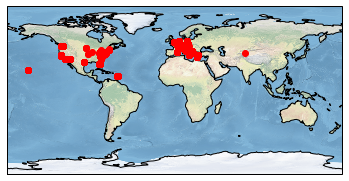

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.plot(df['Longitude'], df['Latitude'], 'o', color='r', transform=ccrs.PlateCarree())

ax.stock_img()
ax.coastlines()


plt.show()

## ArcGIS Pro

If you have an ArcGIS Pro account or know someone who does, this is the easiest way to make the best maps. There are many courses on Geographic Infromation Systems (GIS) that use software like ArcGIS Pro to map data and perform analysis. I will not show you how this can be done, but give a few hints to get you started.

1. Add data to the current map
2. Analysis > Tools > XY Table to Point (Data Management Tools)
3. Analysis > Tools > Recerse Geocode (Geocoding Tools)